# Horizontal and vertical weighting of soil moisture observations

**For the time being, this notebook is a sandbox.** Step by step, we will migrate mature functions to the actual `cosmicsense` library.

The horizontal and vertical weighting equations used here originate from different references: Zreda et al. (2008), Franz et al. (2012), Bogena et al. (2013), Koehli et al. (2015), and Schroen et al. (2017).  Yet, the present implementation is only based on the overview and benchmark study by [Schroen et al. (2017)](https://www.hydrol-earth-syst-sci.net/21/5009/2017/).

In [24]:
# Standard packages
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import numpy as np
import pandas as pd

In [25]:
import cosmicsense as cs

In [26]:
# Display figures inline
%matplotlib inline
# Display figures as interactive (requires kernel restart)
#%matplotlib

## Horizontal footprint and weighting

### Functions that are independent of environmental conditions

Horizontal weighting functions have been - implicitely or explicitely - presented by Zreda et al. (2008) and Bogena et al. (2013).

In [27]:
def horizontal_weight_zreda2008a(r):
    """Horizontal weights according to Zreda et al. (2008).
    
    The actual function was presented in Schroen et al. (2017).

    Parameters
    ----------
    r : float or 1d array of floats
       Distance to the CRNS probe (in meters)
       
    """
    return np.exp(-r / 127.)

def horizontal_weight_zreda2008b(r, a1=1.311e-2, a2=9.423e-5, a3=3.2e-7, a4=3.95e-10):
    """Presented by Bogena et al. (2013, Eq. 13), fitted to Zreda et al. (2008).
    
    Bogena et al. (2013) fitted a polynomial function through the relationship between
    cumulative fraction of counts (CFoC) and CRP footprint radius (r) presented by 
    Zreda et al. (2008).

    Parameters
    ----------
    r : float or 1d array of floats
       Distance to the CRNS probe (in meters)
       
    """
    return 1 - a1 * r + a2 * r**2 - a3 * r**3 + a4 * r**4

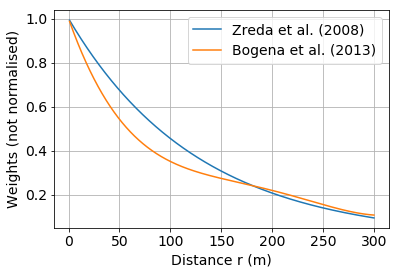

In [28]:
plt.rc('font', **{'size'   : 14})
r = np.arange(1, 300, 0.1)
plt.plot(r, horizontal_weight_zreda2008a(r), label="Zreda et al. (2008)")
plt.plot(r, horizontal_weight_zreda2008b(r), label="Bogena et al. (2013)")
plt.xlabel("Distance r (m)")
plt.ylabel("Weights (not normalised)")
plt.grid()
_ = plt.legend()

### Functions that depend of environmental conditions

Later, revised horizontal weighting functions have been proposed by Koehli et al. (2015), based on URANOS simulations. A set of functions together with the following table of function parameters was presented in Appendix A of Schroen et al. (2017).

In [29]:
pars = np.array([
    [3.7,       np.nan,   np.nan,    np.nan,   np.nan,     np.nan,   np.nan],
    [8735,      22.689,   11720,     0.00978,  9306,       0.003632, np.nan],
    [2.7925e-2, 6.6577,   0.028544,  0.002455, 6.851e-005, 12.2755,  np.nan],
    [247970,    23.289,   374655,    0.00191,  258552,     np.nan,   np.nan],
    [5.4818e-2, 21.032,   0.6373,    0.0791,   5.425e-4,   np.nan,   np.nan],
    [39006,     15002337, 2009.24,   0.01181,  3.146,      16.7417,  3727],
    [6.031e-5,  98.5,     0.0013826, np.nan,   np.nan,     np.nan,   np.nan],
    [11747,     55.033,   4521,      0.01998,  0.00604,    3347.4,   0.00475],
    [1.543e-2,  13.29,    1.807e-2,  0.0011,   8.81e-5,    0.0405,   26.74],
    [0.4922,    0.86,     np.nan,    np.nan,   np.nan,     np.nan,   np.nan],
    [0.17,      0.41,     9.25,      np.nan,   np.nan,     np.nan,   np.nan],
    [8.321,     0.14249,  0.96655,   0.01,     20.0,       0.0429,   np.nan]])
pars = pd.DataFrame(pars, 
                    index=["F0", "F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "Fp", "Fveg", "D86"],
                    columns = ["p0", "p1", "p2", "p3", "p4", "p5", "p6"])
pars

,p0,p1,p2,p3,p4,p5,p6
F0,3.700000,NaN,NaN,NaN,NaN,NaN,NaN
F1,8735.000000,2.268900e+01,11720.000000,0.009780,9306.000000,0.003632,NaN
F2,0.027925,6.657700e+00,0.028544,0.002455,0.000069,12.275500,NaN
F3,247970.000000,2.328900e+01,374655.000000,0.001910,258552.000000,NaN,NaN
F4,0.054818,2.103200e+01,0.637300,0.079100,0.000543,NaN,NaN
F5,39006.000000,1.500234e+07,2009.240000,0.011810,3.146000,16.741700,3727.00000
F6,0.000060,9.850000e+01,0.001383,NaN,NaN,NaN,NaN
F7,11747.000000,5.503300e+01,4521.000000,0.019980,0.006040,3347.400000,0.00475
F8,0.015430,1.329000e+01,0.018070,0.001100,0.000088,0.040500,26.74000
Fp,0.492200,8.600000e-01,NaN,NaN,NaN,NaN,NaN


However, the implementation of functions and their parameters is more strraightforward using keyword arguments.

In [30]:
def F0(p0=3.7):
    return p0

def F1(theta, h, p0=8735., p1=22.689, p2=11720., p3=0.00978, p4=9306., p5=0.003632):
    return p0 * (1 + p3 * h) * np.exp(-p1 * theta) + p2 * (1 + p5 * h) - p4 * theta

def F2(theta, h, p0=0.027925, p1=6.6577, p2=0.028544, p3=0.002455, p4=6.851e-5, p5=12.2755):
    return ((p4 * h - p0) * np.exp(-p1 * theta / (1 + p5 * theta)) + p2) * (1 + p3 * h)

def F3(theta, h, p0=247970., p1=23.289, p2=374655., p3=0.00191, p4=258552.):
    return p0 * (1 + p3 * h) * np.exp(-p1 * theta) + p2 - p4 * theta

def F4(theta, h, p0=0.054818, p1=21.032, p2=0.6373, p3=0.0791, p4=5.425e-4):
    return p0 * np.exp(-p1 * theta) + p2 - p3 * theta +  p4 * h

def F5(theta, h, p0=39006., p1=15002330, p2=2009.24, p3=0.01181, p4=3.146, p5=16.7417, p6=3727.):
    return (p0 - p1 / (p2 * theta + h - 0.13)) * (p3 - theta) * np.exp(-p4 * theta) - p5 * h * theta + p6

def F6(theta, h, p0=6.031e-5, p1=98.5, p2=0.0013826):
    return p0 * (h + p1) + p2 * theta

def F7(theta, h, p0=11747., p1=55.033, p2=4521., p3=0.01998, p4=0.00604, p5=3347.4, p6=0.00475):
    return (p0 * (1 - p6 * h) * np.exp(-p1 * theta * (1 - p4 * h)) + p2 - p5 * theta) * (2 + p3 * h)

def F8(theta, h, p0=0.01543, p1=13.29, p2=0.01807, p3=0.0011, p4=8.81e-5, p5=0.0405, p6=26.74):
    return ((p4 * h - p0) * np.exp(-p1 * theta / (1 + p5 * h + p6 * theta)) + p2) * (2 + p3 * h)

def Fp(press, p0=0.4922, p1=0.86):
    return p0 / (p1 - np.exp(-press / 1013.))

def Fveg(theta, Hveg, p0=0.17, p1=0.41, p2=9.25):
    return 1 - p0 * (1 - np.exp(-p1 * Hveg)) * (1 + np.exp(-p2 * theta))

def rescale_r(r, press, Hveg, theta):
    return r / Fp(press) / Fveg(theta, Hveg)

Based on these functions, the actual horizontal weighting function is defined, together with an approximation for average soil moisture and air humidity conditions.

In [31]:
def horizontal_weight_koehli(r, press, Hveg, theta, h):
    """Horizontal weights presented by Koehli et al. (2015), modified by Schroen et al. (2017)
    
    Parameters
    ----------
    r : float or 1d array of floats
       Distance to the CRNS probe (in meters)
       
    """
    # Container
    r = np.asarray(r)
    x = np.zeros(r.shape) * np.nan
    r_st = rescale_r(r, press, Hveg, theta)
    # Index arrays
    ix1 = r <= 1
    ix2 = (r > 1) & (r <= 50)
    ix3 = (r > 50) & (r < 600)
    # r <= 1 m
    r1 = r[ix1]
    x[ix1] = (F1(theta, h) * np.exp(-F2(theta, h) * r_st[ix1]) + F3(theta, h) * np.exp(-F4(theta, h) * r_st[ix1])) \
    * (1 - np.exp(-F0() * r_st[ix1]))
    # r > 1m and r <= 50 m
    r2 = r[ix2]
    x[ix2] = F1(theta, h) * np.exp(-F2(theta, h) * r_st[ix2]) + F3(theta, h) * np.exp(-F4(theta, h) * r_st[ix2])
    # r > 50 m and r < 600 m
    r3 = r[ix3]
    x[ix3] = F5(theta, h) * np.exp(-F6(theta, h) * r_st[ix3]) + F7(theta, h) * np.exp(-F8(theta, h) * r_st[ix3])
    
    return x

def horizontal_weight_koehli_approx(r):
    """Approximation adopted from Appendix B of Schroen et al. (2017).

    Parameters
    ----------
    r : float or 1d array of floats
       Distance to the CRNS probe (in meters)   

    """
    r = np.asarray(r)
    x = np.zeros(r.shape) * np.nan
    # Index arrays
    ix1 = r <= 1
    ix2 = r > 1
    r1 = r[ix1]
    x[ix1] = (30 * np.exp(-r1 / 1.6) + np.exp(-r1 / 100)) * (1 - np.exp(-3.7 * r1))
    r2 = r[ix2]
    x[ix2] = 30 * np.exp(-r2 / 1.6) + np.exp(-r2 / 100)
    
    return x    

### Comparison of different weighting functions and parameters

The upper panel of the following figure tries to mimic Figure 2 in Schroen et al. (2017)

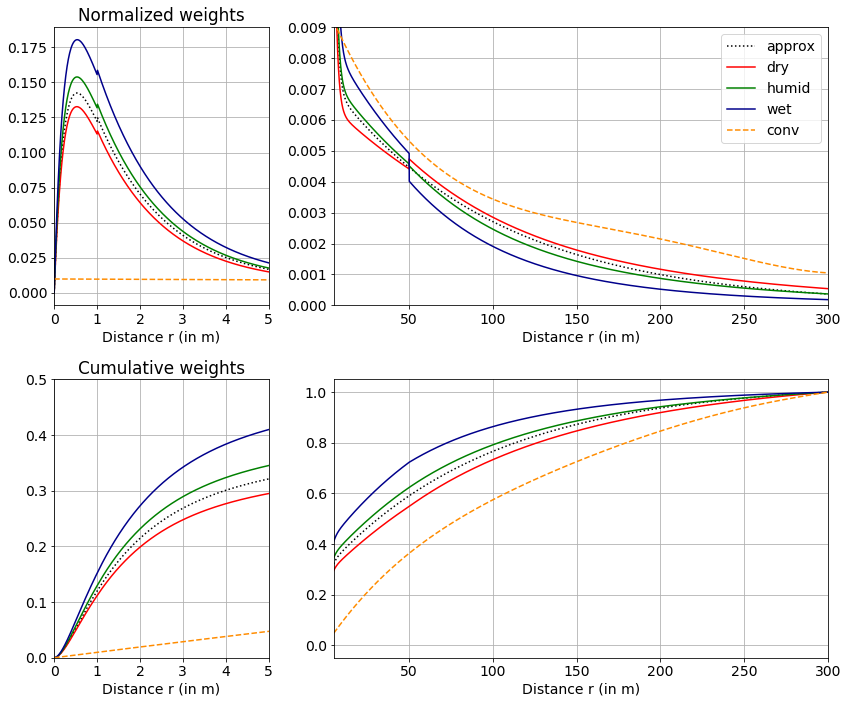

In [32]:
r = np.arange(0., 300, 0.01)
press = 1013.
Hveg = 0.

weights_approx = horizontal_weight_koehli_approx(r)
weights_dry = horizontal_weight_koehli(r, press=press, Hveg=Hveg, theta=0.1, h=5)
weights_humid = horizontal_weight_koehli(r, press=press, Hveg=Hveg, theta=0.2, h=10)
weights_wet = horizontal_weight_koehli(r, press=press, Hveg=Hveg, theta=0.4, h=15)
weights_zreda = horizontal_weight_zreda2008b(r)

def normfunc(x):
    x = 100 * x / np.sum(x)
    return x
  
#normfunc = np.linalg.norm

weights_approx_norm = normfunc(weights_approx)
weights_dry_norm = normfunc(weights_dry)
weights_humid_norm = normfunc(weights_humid)
weights_wet_norm = normfunc(weights_wet)
weights_zreda_norm = normfunc(weights_zreda)

plt.rc('font', **{'size'   : 14})

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=1, rowspan=1)
plt.plot(r, weights_approx_norm, color="black", linestyle = "dotted", label="approx")
plt.plot(r, weights_dry_norm, color="red", label="dry")
plt.plot(r, weights_humid_norm, color="green", label="humid")
plt.plot(r, weights_wet_norm, color="darkblue", label="wet")
plt.plot(r, weights_zreda_norm, color="darkorange", ls = "dashed", label="conv")
plt.xlabel("Distance r (in m)")

ax1.set_xlim(0, 5)
#plt.ylim(0, 0.03)
ax1.grid()
ax1.set_title("Normalized weights")

#ax2 = plt.subplot(2,2,4)
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=2, rowspan=1)
plt.plot(r, weights_approx_norm, color="black", linestyle = "dotted", label="approx")
plt.plot(r, weights_dry_norm, color="red", label="dry")
plt.plot(r, weights_humid_norm, color="green", label="humid")
plt.plot(r, weights_wet_norm, color="darkblue", label="wet")
plt.plot(r, weights_zreda_norm, color="darkorange", ls = "dashed", label="conv")
plt.xlabel("Distance r (in m)")
plt.legend()
plt.xlim(5, 300)
plt.ylim(0, 0.009)
plt.grid()

def normfunc(x):
    x = np.cumsum(x)
    return x / np.max(x)
weights_approx_norm = normfunc(weights_approx)
weights_dry_norm = normfunc(weights_dry)
weights_humid_norm = normfunc(weights_humid)
weights_wet_norm = normfunc(weights_wet)
weights_zreda_norm = normfunc(weights_zreda)

ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=1)
plt.plot(r, weights_approx_norm, color="black", linestyle = "dotted", label="approx")
plt.plot(r, weights_dry_norm, color="red", label="dry")
plt.plot(r, weights_humid_norm, color="green", label="humid")
plt.plot(r, weights_wet_norm, color="darkblue", label="wet")
plt.plot(r, weights_zreda_norm, color="darkorange", ls = "dashed", label="conv")
plt.xlabel("Distance r (in m)")
plt.grid()
plt.xlim(0, 5)
plt.ylim(0, 0.5)
plt.title("Cumulative weights")

ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=2)
plt.plot(r, weights_approx_norm, color="black", linestyle = "dotted", label="approx")
plt.plot(r, weights_dry_norm, color="red", label="dry")
plt.plot(r, weights_humid_norm, color="green", label="humid")
plt.plot(r, weights_wet_norm, color="darkblue", label="wet")
plt.plot(r, weights_zreda_norm, color="darkorange", ls = "dashed", label="conv")
plt.xlabel("Distance r (in m)")
plt.grid()
plt.xlim(5, 300)


plt.tight_layout()

### Questions

- Why is the horizontal weight decreasing within the first 50 centimeters?
- Are the discontinuities at 1 and 50 meters intended? They are also present in the R code provided in the Supplement of Schroen et al. (2017), but not in the paper itself.
- Which approach is recommended for normalisation of weights? Does it matter when different functions are compared?

## Vertical footprint and weighting

Vertical weighting functions had been suggested by Franz et al. (2012), among others, in which the penetration depth depended on soil moisture, but not on the distance to the probe. Again, revised vertical weighting functions were presented by Koehli et al. (2015) and Schroen et al. (2017). These are based on URANOS simulations and take into account the decrease of penetration depth with distance to the probe. 

In [33]:
def penetration_depth_franz(theta):
    """Vertical penetration depth as a function of theta.
    
    Based on Franz et al. (2012).
    
    Parameters
    ----------
    theta : float or array of floats
       Volumetric soil moisture (m3/m3)
    
    Returns
    -------
    output : float or array of floats
       Vertical penetration depth (cm)
    
    """
    return 5.8 / (theta + 0.0829)

def vertical_weight_franz(depth, theta):
    """Based on Franz et al. (2012).

    Parameters
    ----------
    depth : float or 1d array of floats
       depth (cm) for which a weight should be returned
    theta : float or array of floats
       Average volumetric soil moisture (m3/m3) in the footprint
    
    Returns
    -------
    output : float or array of floats of shape ``(len(depth), len(theta))``, squeezed
       Vertical weights
    
    """
    depth = np.atleast_1d(depth)
    theta = np.atleast_1d(theta)
    D = penetration_depth_franz(theta)
    depth, D = np.meshgrid(depth, D)
    x = np.zeros(depth.shape)
    ix = depth <= D
    x[ix] = 1. - depth[ix] / D[ix]

    return np.squeeze(x)


def D86(r, theta, press, Hveg, rhob, p0=8.321, p1=0.14249, p2=0.96655, p3=0.01, p4=20., p5=0.0429):
    """Penetration depth, or rather the depth within which 86 % of neutrons probed the soil.
    
    Based on Koehli et al. (2015) and Schroen et al. (2017).

    Parameters
    ----------
    depth : float or 1d array of floats
       depth (cm) for which a weight should be returned
    theta : float or array of floats
       Average volumetric soil moisture (m3/m3) in the footprint
    press : float
       Barometric pressure (hPa)
    Hveg : float
       Vegetation height (UNIT???)
    rhob : float
       Soil bulk density (kg/l)
    p0 - p5: floats
       Parameters
    
    Returns
    -------
    output : float or array of floats of shape ``(len(r), len(theta))``, squeezed
       Penetration depth (cm)
    
    """
    r = np.atleast_1d(r)
    theta = np.atleast_1d(theta)
    r, theta = np.meshgrid(r, theta, indexing="ij")
    x = (1 / rhob) * (p0 + p1 * (p2 + np.exp(-p3 * rescale_r(r, press, Hveg, theta))) * (p4 + theta) / (p5 + theta))
    return np.squeeze(x) 
        
def vertical_weight_koehli(r, depth, theta, press, Hveg, rhob):
    """Vertical weights for gven distance, depth, and environmental conditions.
    
    Based on Koehli et al. (2015) and Schrön et al. (2017).
    
    Parameters
    ----------
    r : float of 1d-array of floats
    depth : float or 1d-array of floats
    theta : float
    press : float
    Hveg : float
    rhob : float

    Returns
    -------
    output : float or array of floats of shape ``(len(r), len(depth))``, squeezed
       Dimensionless weights
    
    """
    r = np.atleast_1d(r)
    depth = np.atleast_1d(depth)
    D = D86(r, theta, press, Hveg, rhob)
    depth, D = np.meshgrid(depth, D, indexing="ij")
    x = np.exp(-2 * depth / D)
    return np.squeeze(x)

In [34]:
press = 1013. # barometric pressure (in hPa)
Hveg = 0.
rhob = 1.4 # bulk density in kg/l
r = np.arange(0., 350, 50)
theta = np.arange(0.0, 0.6, 0.01)

# Penetration depths for combinations of distance and theta
D_koehli = D86(r, theta, press, Hveg, rhob)
D_franz = penetration_depth_franz(theta) * 100

# Normalised vertical weights
#depths = np.linspace(0, 30, 12)
depths = np.arange(0, 31, 1)
vweights = vertical_weight_koehli(1, depths, 0.17, press, Hveg, rhob)
vweights = vweights / np.sum(vweights)
vweights_franz = vertical_weight_franz(depths, 0.17)
vweights_franz = vweights_franz / np.sum(vweights_franz)

D86_dry = D86(r, 0.1, press, Hveg, rhob)
D86_humid = D86(r, 0.2, press, Hveg, rhob)
D86_wet = D86(r, 0.4, press, Hveg, rhob)

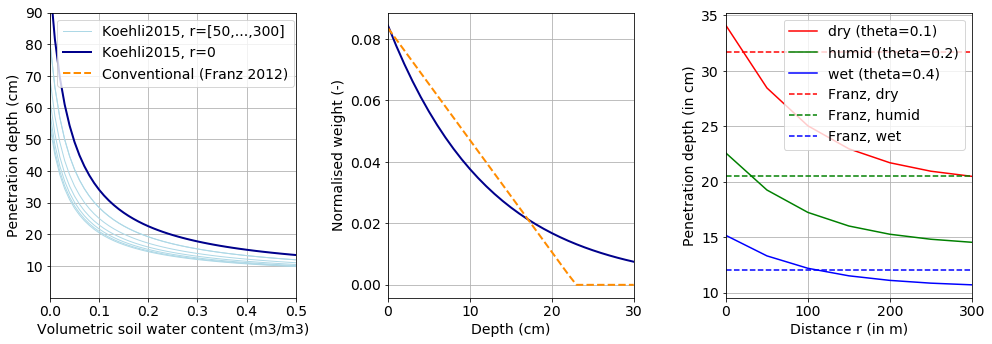

In [35]:
plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.plot(theta, D_koehli.T, color="lightblue", lw=1)
plt.plot(theta, D_koehli[1,:], color="lightblue", lw=1, label="Koehli2015, r=[50,...,300]")
plt.plot(theta, D_koehli[0,:], color="darkblue", lw=2, label="Koehli2015, r=0")
plt.plot(theta, D_franz, color="darkorange", ls="dashed", lw=2, label="Conventional (Franz 2012)")
plt.yticks(range(10,100,10))
plt.xlim(0,0.5)
plt.ylim(0,90)
plt.grid()
plt.xlabel("Volumetric soil water content (m3/m3)")
plt.ylabel("Penetration depth (cm)")
plt.legend()

plt.subplot(1,3,2)
plt.plot(depths, vweights, color="darkblue", lw=2)
plt.plot(depths, vweights_franz, color="darkorange", ls="dashed", lw=2)
plt.grid()
plt.xlim(0,30)
plt.xlabel("Depth (cm)")
plt.ylabel("Normalised weight (-)")


plt.subplot(1,3,3)#plt.subplot2grid((2, 3), (0, 0), colspan=1, rowspan=1)
plt.plot(r, D86_dry, color="red", label="dry (theta=0.1)")
plt.plot(r, D86_humid, color="green", label="humid (theta=0.2)")
plt.plot(r, D86_wet, color="blue", label="wet (theta=0.4)")
plt.axhline(penetration_depth_franz(0.1), color="red", ls="dashed", label="Franz, dry")
plt.axhline(penetration_depth_franz(0.2), color="green", ls="dashed", label="Franz, humid")
plt.axhline(penetration_depth_franz(0.4), color="blue", ls="dashed",  label="Franz, wet")
plt.xlabel("Distance r (in m)")
plt.ylabel("Penetration depth (in cm)")
plt.legend()
plt.xlim(0,300)
plt.grid()

plt.tight_layout()

R-Code has been provided in [Schrön et al. (2017) Supplement](https://www.hydrol-earth-syst-sci.net/21/5009/2017/hess-21-5009-2017-supplement.zip).